# Задание 3. Выделение границ/сегментация, преобразование Хафа/текстурный анализ (Вариант 2)

### 1. Алгоритм выделения границ Канни

**1) Импортируем окружение**

In [1]:
import cv2
import statistics as st
import math
import time
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy as np
import random
print(cv2.__version__)

4.4.0


**2) Импортируем изображение**

In [2]:
image = cv2.imread("img1.jpg")

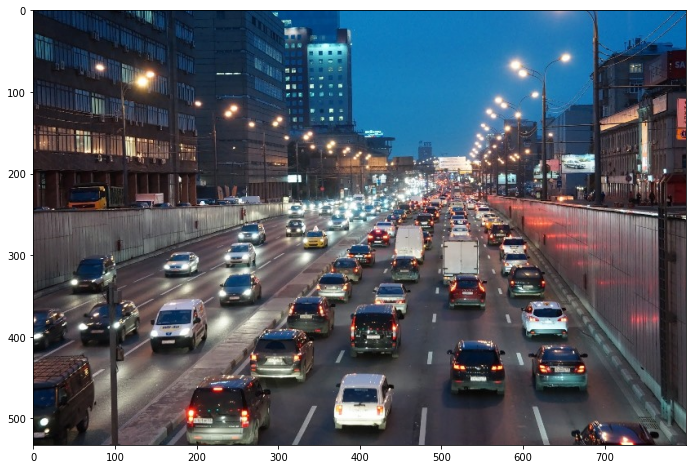

In [3]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

**3) Переводим изображение в монохром**

In [4]:
def to_gray(image):
    image2 = np.empty([image.shape[0], image.shape[1]])
    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            pixel = image[i, j]
            average = int(pixel[0]) * 0.114 + int(pixel[1]) * 0.587 + int(pixel[2]) * 0.229
            image2[i, j] = average
    return image2

In [5]:
image2 = to_gray(image)

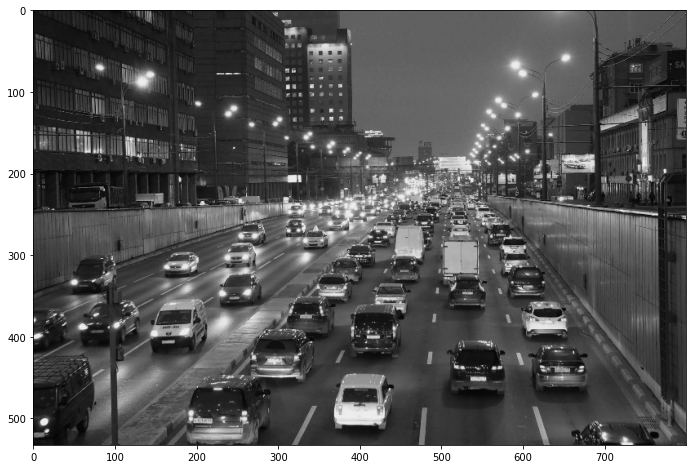

In [6]:
plt.figure(figsize=(12, 8))
plt.imshow(image2, cmap='gray', vmin = 0, vmax = 255)

**4) Размываем гаусом**

In [7]:
def convolution(img, kernel):
    image_h = img.shape[0]
    image_w = img.shape[1]    
    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    image_pad = np.pad(img, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2)), mode='constant', constant_values=0).astype(np.float32)
    h = kernel_h // 2
    w = kernel_w // 2
    
    image_conv = np.zeros(image_pad.shape)
    
    for i in range(h, image_pad.shape[0] - h):
        for j in range(w, image_pad.shape[1] - w):
            x = image_pad[i - h : i - h + kernel_h, j - w : j - w + kernel_w]
            x = x.flatten() * kernel.flatten()
            image_conv[i][j] = x.sum()
    h_end = -h
    w_end = -w
    
    if(h == 0):
        return image_conv[h :, w : w_end]
    if(w == 0):
        return image_conv[h : h_end, w:]
    return image_conv[h : h_end, w:w_end]

def gaussian_filter(img, sigma):
    kernel_size = 2 * int(4 * sigma + 0.5) + 1
    kernel = np.zeros((kernel_size, kernel_size), np.float32)
    m = kernel_size // 2
    n = kernel_size // 2
    
    for x in range(-m, m + 1):
        for y in range(-n, n + 1):
            x1 = 2 * np.pi * (sigma ** 2)
            x2 = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
            kernel[x + m, y + n] = (1 / x1) * x2
    
    img_filtered = np.zeros_like(img, dtype = np.float32)
    img_filtered[:, :] = convolution(img[:, :], kernel)
    return (img_filtered.astype(np.uint8))

In [8]:
image3 = gaussian_filter(image2, 0.8)

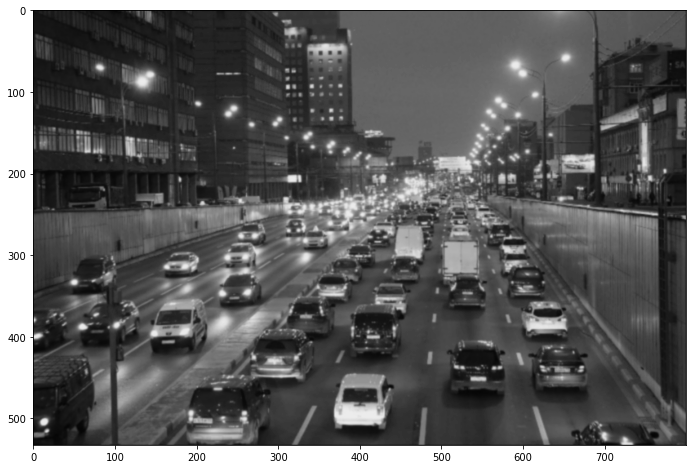

In [9]:
plt.figure(figsize=(12, 8))
plt.imshow(image3, cmap='gray', vmin = 0, vmax = 255)

**5) Считаем градиент**

In [10]:
def get_grad(image):
    image2 = np.empty([image.shape[0], image.shape[1]])
    Gy = np.empty([image.shape[0], image.shape[1]])
    Gx = np.empty([image.shape[0], image.shape[1]])
    teta = np.empty([image.shape[0], image.shape[1]])
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            Gy[i, j] = image[i+1, j-1] + 2*image[i+1, j] + image[i+1, j-1] - image[i-1, j-1] - 2*image[i-1, j] - image[i-1, j+1]
            Gx[i, j] = image[i-1, j+1] + 2*image[i, j+1] + image[i+1, j+1] - image[i-1, j-1] - 2*image[i, j-1] - image[i+1, j-1]
            image2[i, j] = math.sqrt(Gy[i, j] ** 2 + Gx[i, j] ** 2)
            teta[i, j] = round(math.atan2(Gy[i, j], Gx[i, j]) / math.pi * 4) * math.pi / 4
    return image2, teta

In [11]:
image4, teta = get_grad(image3)

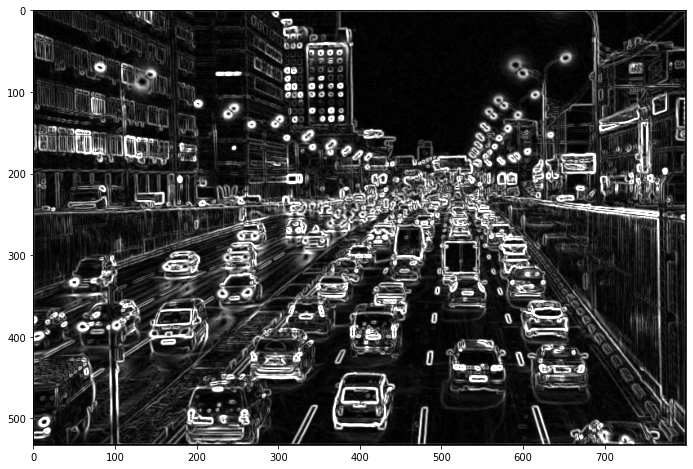

In [12]:
plt.figure(figsize=(12, 8))
plt.imshow(image4, cmap='gray', vmin = 0, vmax = 255)

**6) Подавление не максимумов**

In [13]:
def separation_of_max(image, teta):
    image2 = image.copy()
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if np.abs(teta[i,j] + math.pi) < 0.0001 or np.abs(teta[i,j] - math.pi) < 0.0001 or np.abs(teta[i,j]) < 0.0001:
                if image[i,j] < image[i,j-1] or image[i,j] < image[i,j+1]:
                    image2[i,j] = 0
            elif np.abs(teta[i,j] + math.pi / 2) < 0.0001 or np.abs(teta[i,j] - math.pi / 2) < 0.0001:
                if image[i,j] < image[i-1,j] or image[i,j] < image[i+1,j]:
                    image2[i,j] = 0
            elif np.abs(teta[i,j] - math.pi / 4) < 0.0001 or np.abs(teta[i,j] + 3 * math.pi / 4) < 0.0001:
                if image[i,j] < image[i-1,j+1] or image[i,j] < image[i+1,j-1]:
                    image2[i,j] = 0
            elif np.abs(teta[i,j] + math.pi / 4) < 0.0001 or np.abs(teta[i,j] - 3 * math.pi / 4) < 0.0001:
                if image[i,j] < image[i-1,j-1] or image[i,j] < image[i-1,j-1]:
                    image2[i,j] = 0
    return image2

In [14]:
image5 = separation_of_max(image4, teta)

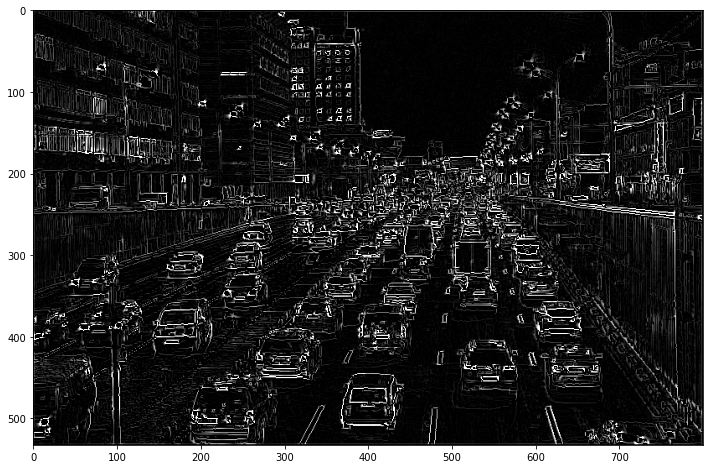

In [15]:
plt.figure(figsize=(12, 8))
plt.imshow(image5, cmap='gray', vmin = 0, vmax = 255, aspect='auto')

**7) Двойная пороговая фильтрация**

In [16]:
def filtration(image, up, down):
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i,j] > up:
                image[i,j] = 255
            elif image[i,j] < down:
                image[i,j] = 0
            else:
                image[i,j] = 127
    return image

In [17]:
image6 = filtration(image5, 90, 60)

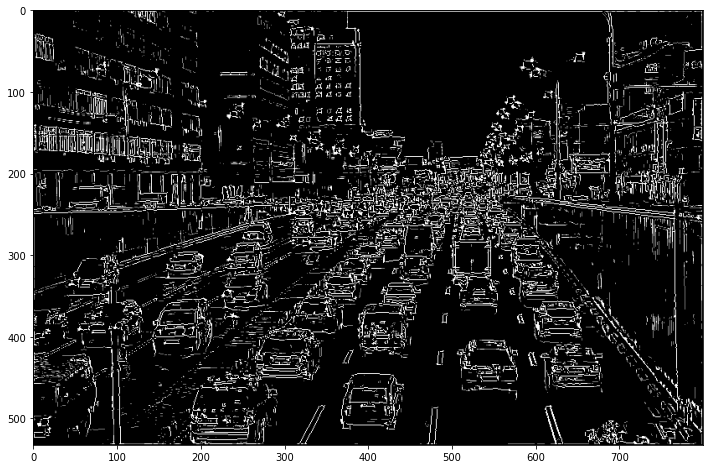

In [18]:
plt.figure(figsize=(12, 8))
plt.imshow(image6, cmap='gray', vmin = 0, vmax = 255, aspect='auto')

**8) Трассировка области неоднозначности**

In [23]:
image7 = image6.copy()

def tracing(x, y):
    if image7[x-1, y] == 127:
        image7[x-1, y] = 255
        tracing(x-1, y)
    if image7[x-1, y-1] == 127:
        image7[x-1, y-1] = 255
        tracing(x-1, y-1)
    if image7[x-1, y+1] == 127:
        image7[x-1, y+1] = 255
        tracing(x-1, y+1)
    if image7[x+1, y] == 127:
        image7[x+1, y] = 255
        tracing(x+1, y)
    if image7[x+1, y-1] == 127:
        image7[x+1, y-1] = 255
        tracing(x+1, y-1)
    if image7[x+1, y+1] == 127:
        image7[x+1, y+1] = 255
        tracing(x+1, y+1)
    if image7[x, y+1] == 127:
        image7[x, y+1] = 255
        tracing(x, y+1)
    if image7[x, y-1] == 127:
        image7[x, y-1] = 255
        tracing(x, y-1)
    

for i in range(1, image7.shape[0] - 1):
    for j in range(1, image7.shape[1] - 1):
        if image7[i, j] == 255:
            tracing(i, j)
            
for i in range(1, image7.shape[0] - 1):
    for j in range(1, image7.shape[1] - 1):
        if image7[i, j] == 127:
            image7[i, j] = 0

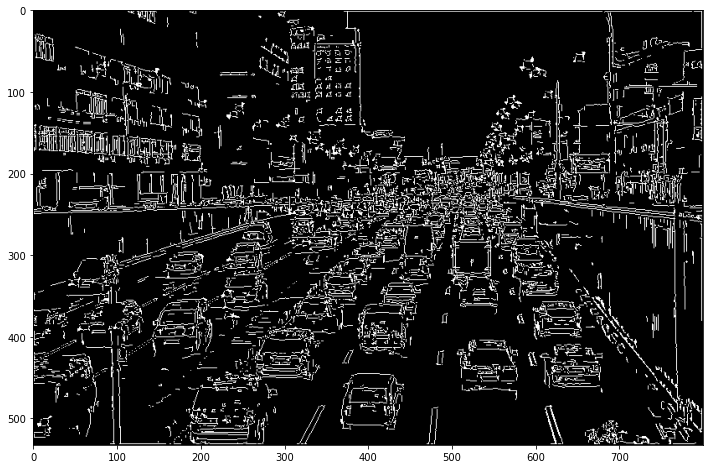

In [24]:
plt.figure(figsize=(12, 8))
plt.imshow(image7, cmap='gray', vmin = 0, vmax = 255, aspect='auto')